# Creation of an artificial neural network from scratch

This notebook currently contains a very basic implementation of an artificial neural network from scratch. 
The first cell contains

1. A definition of several activation functions and their derivatives.
2. A definition of a loss function and its derivative.
3. A definition of the forward propagation through a single layer
4. A definition of a backward propagation through a single layer


Your task is to do the following extentions to the code in this cell:

1. Add support for an additional activation function.
2. Add the use of a bias in the forward- and backward-propagation. 
As it is implemented now, all solutions have to pass the origin.

In [63]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12345)  # Set initial random seed (good to always do)

# Activation functions, the parameter f decides which activation function that is used.
# Added: Sigmoid activation function and its derivative
def activate(a, f="none"):
    if f == "ReLU":
        y = ReLU(a)
    elif f == "softmax":
        y = softmax(a)
    elif f == "sigmoid":
        y = 1 / (1 + np.exp(-a))
    else:
        y = a
    return y


# Derivatives of activation functions
def d_activate(a, f="none"):
    if f == "none":
        dy = np.ones_like(a)
    elif f == "ReLU":
        dy = 1 * (a > 0)
    elif f == "sigmoid":
        dy = activate(a, "sigmoid") * (1 - activate(a, "sigmoid"))
    elif f == "softmax":
        dy = 1

    # print(f)
    return dy


# This is the loss for a set of predictions y_hat compared to a set of real values y
def MSE_loss(y_hat, y):
    return 1/2 * np.mean((y_hat-y)**2)

# This is the derivative of the loss with respect to the predicted value y_hat
def d_MSE_loss(y_hat, y):
    m = y.shape[0]
    return 1./m * (y_hat-y)


# Propagate a signal through a layer in a neural network.
# Added: support for the use of a bias
def propagate_forward(w, b, a, f="none"):
    z = np.dot(a, w) + b

    # Add a print statement to inspect the pre-activation output
    print(f"Pre-activation output before {f} (z): {z.shape}")

    return activate(z, f)


# Calculate the backward gradients that are passed through the layer in the backward pass.
# Returns both the derivative of the loss with respect to the weights w and the input signal a.
# Added: support for a bias
def propagate_backward(w, b, a, dl_dz, f="none"):
    dl = d_activate(np.dot(a, w) + b, f) * dl_dz
    dw = np.dot(a.T, dl)
    db = np.sum(dl, axis=0)
    da = np.dot(dl, w.T)
    return dw, db, da

def ReLU(x):
    return np.maximum(0, x)

def d_ReLU(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def d_softmax_cross_entropy(x, y):
    return x - y



## An implementation of a neural network

Below is an implementation of a MLP neural network. This implementation is still lacking several details that are needed for the network to be robust and function well. Your task is to improve it with the following:

1. Add a bias to the activation functions that are fine tuned during training. 
2. Add a function that trains the network using minibatches (the network only trains on a few samples at a time) 
3. Optional: Make use of an validation set in the training function. The model should hence stop training when the loss starts to increase for the validation set.


In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

class NeuralNet(object):
    # Setup all parameters and activation functions.
    # Added: support for a bias for each neuron
    def __init__(self, input_size, num_classes, hidden_neurons, hidden_activations=[], output_activation='softmax'):
        self.ws = []
        self.bs = []
        self.activations = []
        self.output_dim = num_classes

        last_size = input_size
        for neurons, activation in zip(hidden_neurons, hidden_activations):
            self.ws.append(np.random.randn(last_size, neurons) * np.sqrt(2 / last_size))
            self.bs.append(np.zeros(neurons))
            self.activations.append(activation)
            last_size = neurons

        self.ws.append(np.random.randn(last_size, num_classes) * np.sqrt(2 / last_size))
        self.bs.append(np.zeros(num_classes))
        self.activations.append(output_activation)

        # Print statements to check the output layer
        # print(f"Output layer weights shape: {self.ws[-1].shape}")
        # print(f"Output layer bias shape: {self.bs[-1].shape}")
        # print(f"Output layer activation: {self.activations[-1]}")

    # Predict the input through the network and calculate the output.
    # Added: support for a bias for each neuron
    def forward(self, x):
        for w, b, f in zip(self.ws, self.bs, self.activations):
            x = propagate_forward(w, b, x, f)
        return x

    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    # alpha is the learning rate.
    # Added: support for a bias for each neuron and make sure these are learned as well.
    def adjust_weights(self, x, y, alpha=1e-4):
        a = x
        al = []

        for w, b, f in zip(self.ws, self.bs, self.activations):
            al.append(a)
            a = propagate_forward(w, b, a, f)

            # Add print statements to check shapes during forward propagation
            print(f"Forward propagation shapes for layer with weights {w.shape} and biases {b.shape}:")
            print(f"a: {a.shape}")

            loss = MSE_loss(a, y)
            da = d_MSE_loss(a, y)

        for w, b, f, x in reversed(list(zip(self.ws, self.bs, self.activations, al))):
            dw, db, da = propagate_backward(w, b, x, da, f)

            # Add print statements to check shapes during backward propagation
            print(f"Backward propagation shapes for layer with weights {w.shape} and biases {b.shape}:")
            print(f"dw: {dw.shape}, db: {db.shape}, da: {da.shape}")

            w -= alpha * dw
            b -= alpha * db

        return loss
    
    # A function for the training of the network.
    # Added: a training loop, support for mini batches, and optional training/validation data split
    def train_net(self, x, y, batch_size=64, epochs=100, val_split=0.1, verbose=True, alpha=1e-4):
        n = x.shape[0]
        num_batches = n // batch_size
        val_size = int(n * val_split)
        train_size = n - val_size

        x_train, x_val = x[:train_size], x[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]

        losses = []
        val_losses = []

        for epoch in range(epochs):
            for batch in range(num_batches):
                start = batch * batch_size
                end = min((batch + 1) * batch_size, train_size)
                x_batch = x_train[start:end]
                y_batch = y_train[start:end]

                #     # Add print statements here
                # print(f"x_batch shape: {x_batch.shape}")
                # print(f"y_batch shape: {y_batch.shape}")
                # print(f"y_batch sample: {y_batch[:5]}")

            
                loss = self.adjust_weights(x_batch, y_batch, alpha=alpha)
                losses.append(loss)

            if val_split > 0:
                y_val_pred = self.forward(x_val)
                val_loss = MSE_loss(y_val_pred, y_val)
                val_losses.append(val_loss)
                if verbose:
                    print(f"Epoch {epoch + 1}: Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
            else:
                if verbose:
                    print(f"Epoch {epoch + 1}: Training Loss: {loss:.4f}")

        return losses, val_losses
    
    
    def print_network(self):
        layers = [self.ws[0].shape[0]] + [w.shape[1] for w in self.ws]
        num_layers = len(layers)

        fig, ax = plt.subplots()
        max_neurons = max(layers)

        neuron_positions = []

        for i, neurons in enumerate(layers):
            layer_positions = []
            for j in range(neurons):
                x = i * 2
                y = (max_neurons - neurons) / 2 + j
                circle = plt.Circle((x, y), 0.4, color='blue', fill=True)
                ax.add_artist(circle)
                ax.text(x - 0.15, y - 0.1, str(j + 1), fontsize=10, color='white')
                layer_positions.append((x, y))  
            neuron_positions.append(layer_positions)

        # # Draw connections between neurons
        # for i in range(num_layers - 1):
        #     for neuron1 in neuron_positions[i]:
        #         for neuron2 in neuron_positions[i + 1]:
        #             line = Line2D((neuron1[0], neuron2[0]), (neuron1[1], neuron2[1]), linewidth=0.5, linestyle='-', color='black')
        #             ax.add_artist(line)

        ax.set_xlim(-1, num_layers * 2 - 1)
        ax.set_ylim(-1, max_neurons)
        ax.set_xticks([i * 2 for i in range(num_layers)])
        ax.set_xticklabels(['Input'] + [f'Hidden {i}' for i in range(1, num_layers - 1)] + ['Output'])
        ax.set_yticks([])
        ax.set_aspect('equal')
        plt.title('Neural Network Architecture')
        plt.show()
    
    def accuracy(self, x, y):
        y_pred = self.forward(x)
        y_pred = np.argmax(y_pred, axis=1)
        y = np.argmax(y, axis=1)
        return np.mean(y_pred == y)
        


# Misc Functions

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def load_and_preprocess_dataset(url, feature_cols, target_col, column_names=None, test_size=0.2):
    # Load dataset
    df = pd.read_csv(url, header=None, names=column_names)

    # Split into train and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df[target_col])

    # Create X and y arrays
    X_train = train_df[feature_cols].values
    X_test = test_df[feature_cols].values
    y_train = pd.get_dummies(train_df[target_col]).values
    y_test = pd.get_dummies(test_df[target_col]).values

    return X_train, X_test, y_train, y_test

def one_hot_encode(labels):
    num_classes = len(np.unique(labels))
    one_hot_encoded = np.zeros((labels.shape[0], num_classes))
    one_hot_encoded[np.arange(labels.shape[0]), labels.reshape(-1)] = 1
    return one_hot_encoded



## Main programs

This cell should contain your different programs. In this cell you should present:

1. At least 3 programs where the neural network is applied to 3 different datasets.
2. You should also have at least 2 programs where you fine tune 2 hyper-parameters.

In [66]:
def main1():
    np.random.seed(1234) # Set initial random seed (good to always do)
    n = 1000
    d = 4
    k = np.random.randint(0, 10, (d, 1))
    x = np.random.normal(0, 1, (n, d))
    y = np.dot(x, k) + 0.1 + np.random.normal(0, 0.01, (n, 1))

    nn = NeuralNet(d, 1, [18, 12])

    losses, val_losses = nn.train_net(x, y, batch_size=64, epochs=100, val_split=0.1)

    plt.plot(losses)
    plt.plot(np.arange(0, len(losses), len(losses) // len(val_losses)), val_losses)
    plt.title("Loss")
    plt.legend(['Training', 'Validation'])
    plt.show()


def iris():
    iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    iris_column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
    iris_feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
    iris_target_col = 'species'

    X_train_iris, X_test_iris, y_train_iris, y_test_iris = load_and_preprocess_dataset(iris_url, iris_feature_cols, iris_target_col, column_names=iris_column_names)

    return X_train_iris, X_test_iris, y_train_iris, y_test_iris


def wine():
    wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
    wine_column_names = ['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
    wine_feature_cols = wine_column_names[1:]  # All columns except the first one
    wine_target_col = 'class'

    X_train_wine, X_test_wine, y_train_wine, y_test_wine = load_and_preprocess_dataset(wine_url, wine_feature_cols, wine_target_col, column_names=wine_column_names)

    return X_train_wine, X_test_wine, y_train_wine, y_test_wine


def bc():
    bc_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
    bc_column_names = ['id', 'diagnosis'] + [f"feature_{i}" for i in range(30)]
    bc_feature_cols = [f"feature_{i}" for i in range(30)]
    bc_target_col = 'diagnosis'

    X_train_bc, X_test_bc, y_train_bc, y_test_bc = load_and_preprocess_dataset(bc_url, bc_feature_cols, bc_target_col, column_names=bc_column_names)

    return X_train_bc, X_test_bc, y_train_bc, y_test_bc



def main2():
    X_train_iris, X_test_iris, y_train_iris, y_test_iris = iris()
    X_train_wine, X_test_wine, y_train_wine, y_test_wine = wine()
    X_train_bc, X_test_bc, y_train_bc, y_test_bc = bc()

    nn_iris = NeuralNet(X_train_iris.shape[1], y_train_iris.shape[1], hidden_neurons=[3], hidden_activations=["ReLU"], output_activation='softmax')
    nn_wine = NeuralNet(X_train_wine.shape[1], y_train_wine.shape[1], hidden_neurons=[3], hidden_activations=["ReLU"], output_activation='softmax')
    nn_bc = NeuralNet(X_train_bc.shape[1], y_train_bc.shape[1], hidden_neurons=[2], hidden_activations=["ReLU"], output_activation='softmax')

    # Train the neural networks
    nn_iris.train_net(X_train_iris, y_train_iris, batch_size=64, epochs=100, val_split=0.1, verbose=False)
    nn_wine.train_net(X_train_wine, y_train_wine, batch_size=64, epochs=100, val_split=0.1, verbose=False)
    nn_bc.train_net(X_train_bc, y_train_bc, batch_size=64, epochs=100, val_split=0.1, verbose=False)

    # Evaluate the performance
    test_accuracy_iris = nn_iris.accuracy(X_test_iris, y_test_iris)
    test_accuracy_wine = nn_wine.accuracy(X_test_wine, y_test_wine)
    test_accuracy_bc = nn_bc.accuracy(X_test_bc, y_test_bc)

    print("Test accuracy for Iris dataset:", test_accuracy_iris)
    print("Test accuracy for Wine dataset:", test_accuracy_wine)
    print("Test accuracy for Breast Cancer dataset:", test_accuracy_bc)

main2()



Pre-activation output before ReLU (z): (64, 3)
Forward propagation shapes for layer with weights (4, 3) and biases (3,):
a: (64, 3)
Pre-activation output before softmax (z): (64, 3)
Forward propagation shapes for layer with weights (3, 3) and biases (3,):
a: (64, 3)
Backward propagation shapes for layer with weights (3, 3) and biases (3,):
dw: (3, 3), db: (3,), da: (64, 3)
Backward propagation shapes for layer with weights (4, 3) and biases (3,):
dw: (4, 3), db: (3,), da: (64, 4)
Pre-activation output before ReLU (z): (12, 3)
Pre-activation output before softmax (z): (12, 3)
Pre-activation output before ReLU (z): (64, 3)
Forward propagation shapes for layer with weights (4, 3) and biases (3,):
a: (64, 3)
Pre-activation output before softmax (z): (64, 3)
Forward propagation shapes for layer with weights (3, 3) and biases (3,):
a: (64, 3)
Backward propagation shapes for layer with weights (3, 3) and biases (3,):
dw: (3, 3), db: (3,), da: (64, 3)
Backward propagation shapes for layer with

In [67]:
def grid_search(X_train, y_train, X_val, y_val):
    # Define the hyperparameters for grid search
    learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
    hidden_layers = [(4,), (8,), (16,), (4, 4), (8, 8), (16, 16), (4, 4, 4), (8, 8, 8), (16, 16, 16)]

    # Initialize the best validation accuracy and best hyperparameters
    best_val_accuracy = 0
    best_hyperparameters = None

    # Perform a grid search over the combinations of learning rates and hidden layers
    for lr in learning_rates:
        for hl in hidden_layers:
            # Create a neural network with the current hyperparameters
            nn = NeuralNet(X_train.shape[1], y_train.shape[1], hidden_neurons=hl, hidden_activations=["ReLU"] * len(hl), output_activation='softmax')
            try:
                # return
                
                # Train the neural network with the current hyperparameters
                nn.train_net(X_train, y_train, batch_size=64, epochs=100, val_split=0, verbose=False, alpha=lr)
                
                # Evaluate the neural network on the validation set
                val_accuracy = nn.accuracy(X_val, y_val)

                # Update the best validation accuracy and best hyperparameters if the current combination performs better
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_hyperparameters = {'learning_rate': lr, 'hidden_layers': hl}

                # Print the current hyperparameters and validation accuracy
                print(f"Learning rate: {lr}, Hidden layers: {hl}, Validation accuracy: {val_accuracy}")
            except Exception as e:
                print(e)
                for idx, w in enumerate(nn.ws):
                    print(f"Layer {idx + 1}: {w.shape}")
                print("Biases:")
                for idx, b in enumerate(nn.bs):
                    print(f"Layer {idx + 1}: {b.shape}")
                nn.print_network()

    # Return the best hyperparameters
    return best_hyperparameters


Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (3,)


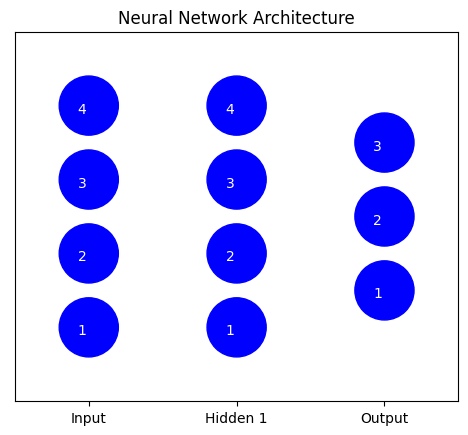

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (3,)


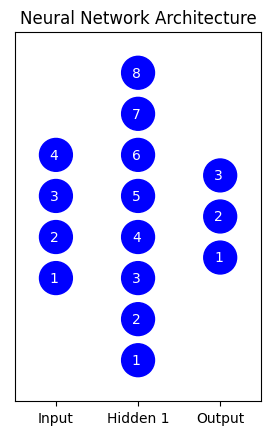

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (3,)


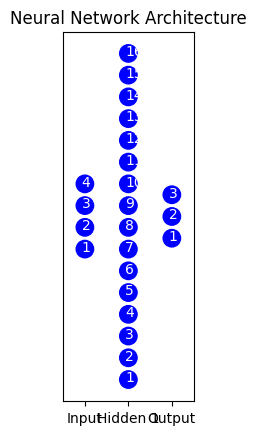

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (3,)


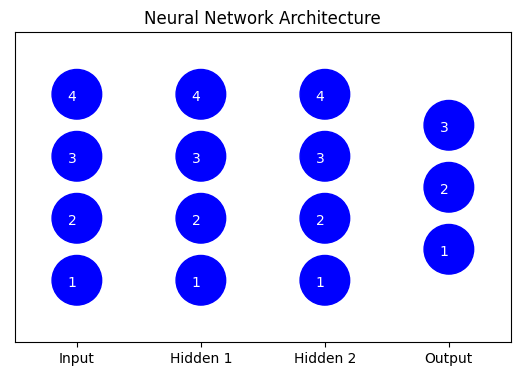

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (3,)


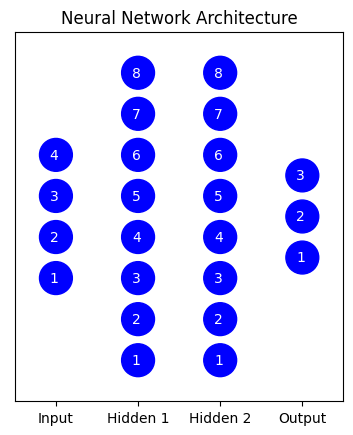

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (3,)


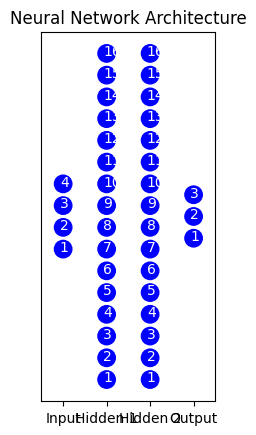

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 4)
Layer 4: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (4,)
Layer 4: (3,)


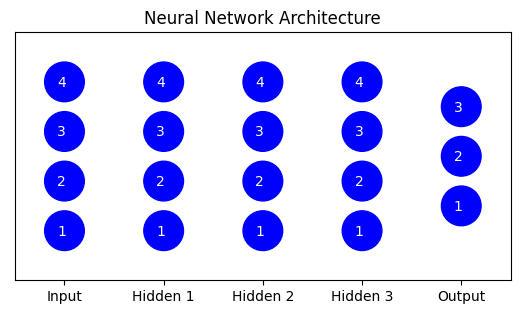

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 8)
Layer 4: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (8,)
Layer 4: (3,)


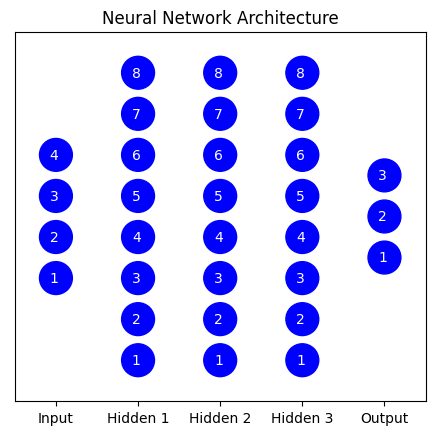

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 16)
Layer 4: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (16,)
Layer 4: (3,)


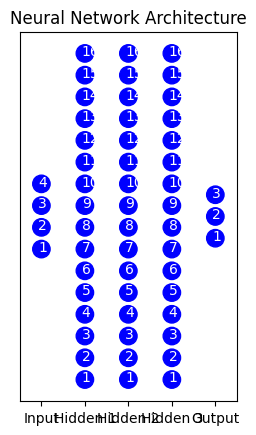

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (3,)


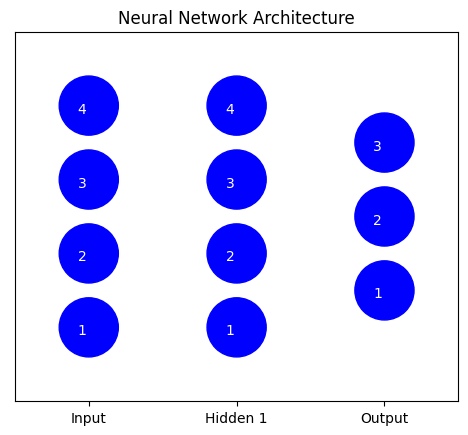

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (3,)


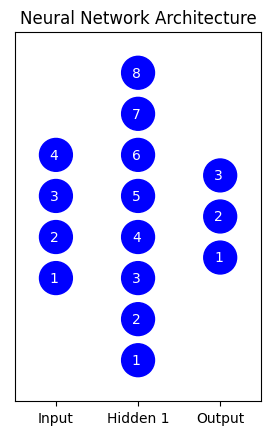

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (3,)


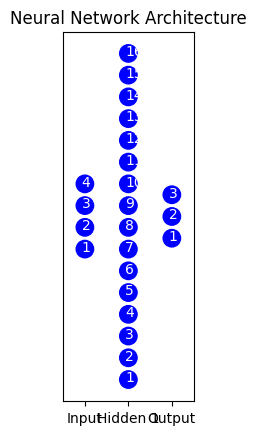

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (3,)


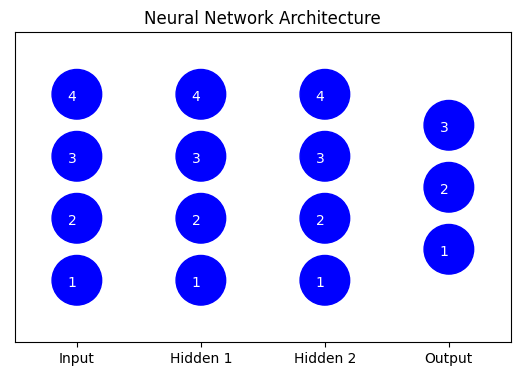

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (3,)


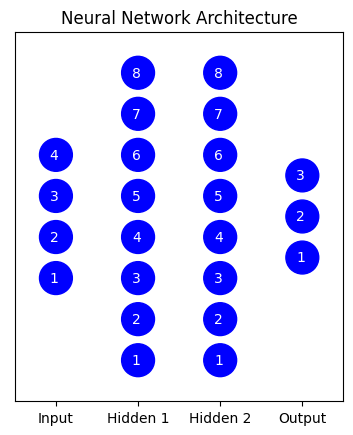

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (3,)


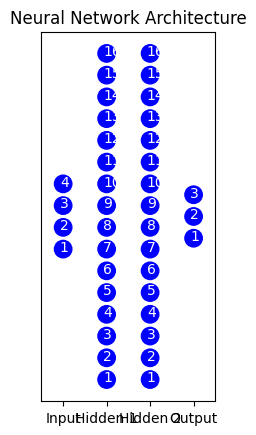

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 4)
Layer 4: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (4,)
Layer 4: (3,)


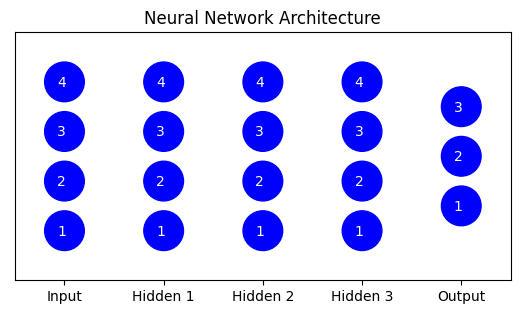

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 8)
Layer 4: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (8,)
Layer 4: (3,)


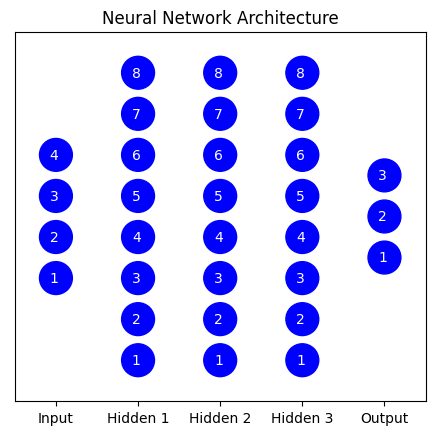

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 16)
Layer 4: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (16,)
Layer 4: (3,)


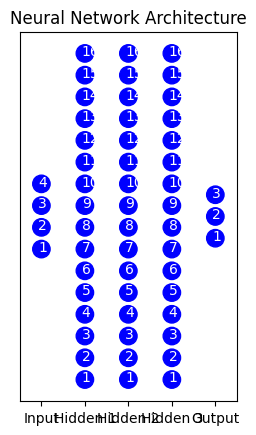

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (3,)


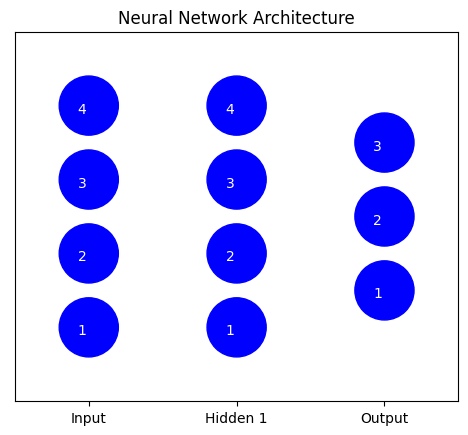

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (3,)


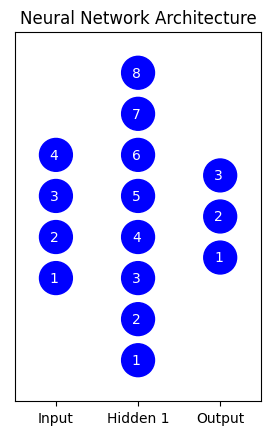

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (3,)


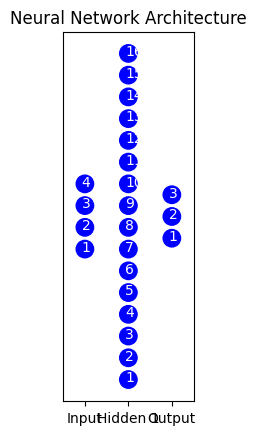

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (3,)


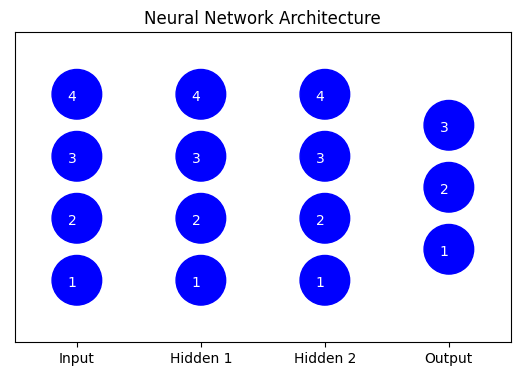

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (3,)


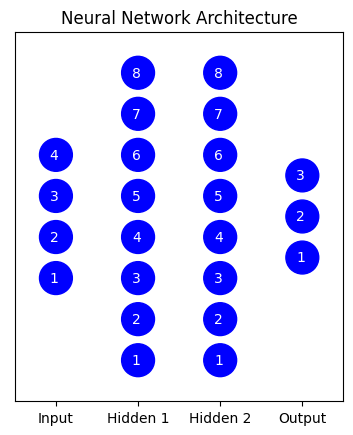

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (3,)


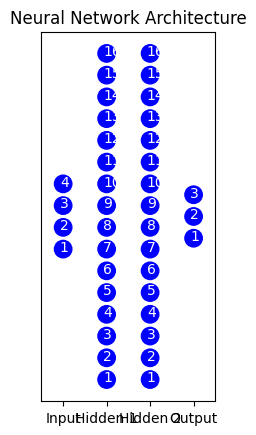

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 4)
Layer 4: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (4,)
Layer 4: (3,)


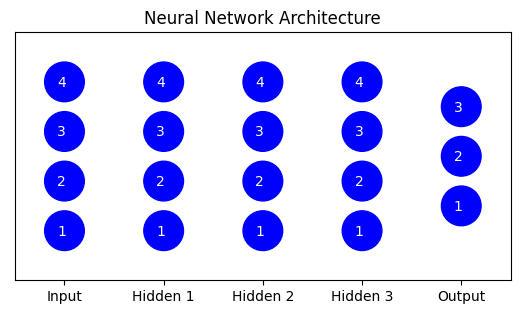

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 8)
Layer 4: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (8,)
Layer 4: (3,)


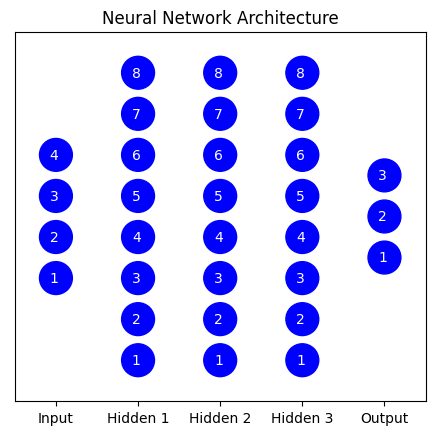

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 16)
Layer 4: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (16,)
Layer 4: (3,)


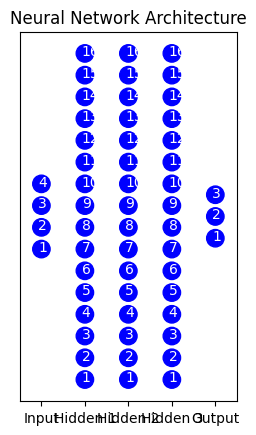

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (3,)


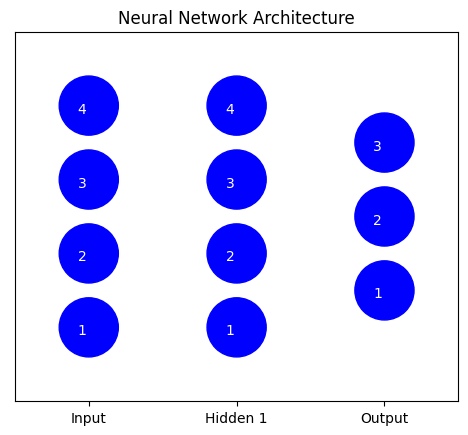

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (3,)


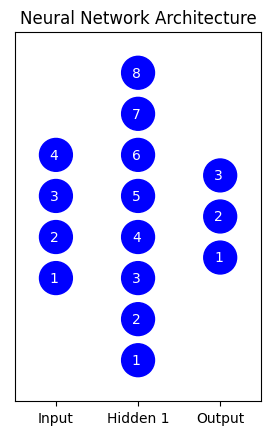

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (3,)


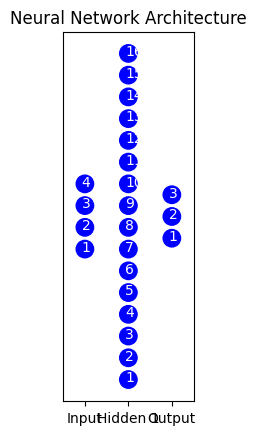

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (3,)


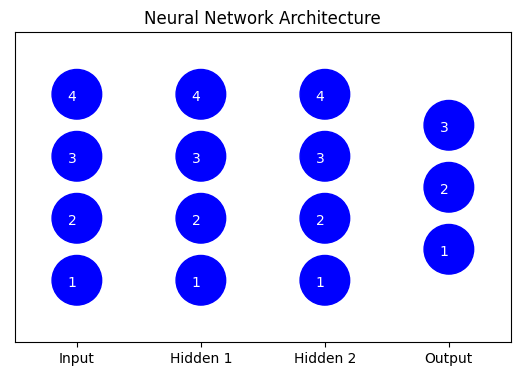

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (3,)


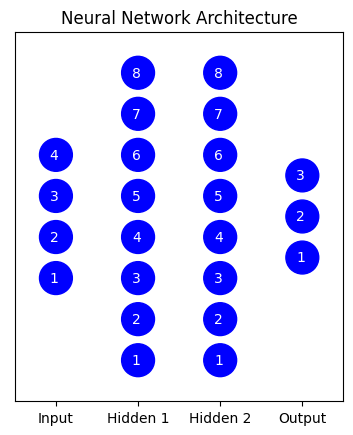

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (3,)


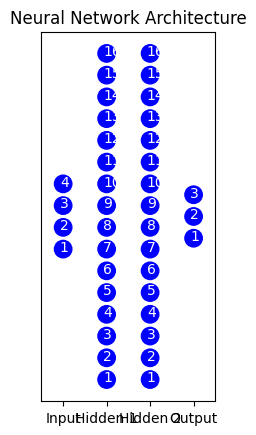

Pre-activation output before ReLU (z): (64, 4)
Forward propagation shapes for layer with weights (4, 4) and biases (4,):
a: (64, 4)
operands could not be broadcast together with shapes (64,4) (64,3) 
Layer 1: (4, 4)
Layer 2: (4, 4)
Layer 3: (4, 4)
Layer 4: (4, 3)
Biases:
Layer 1: (4,)
Layer 2: (4,)
Layer 3: (4,)
Layer 4: (3,)


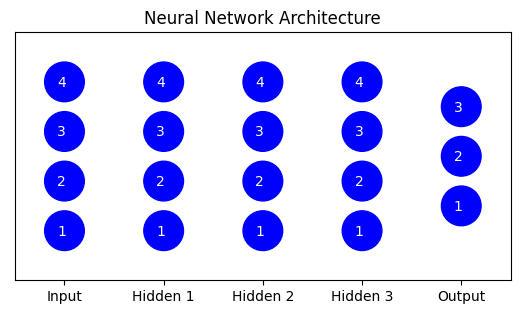

Pre-activation output before ReLU (z): (64, 8)
Forward propagation shapes for layer with weights (4, 8) and biases (8,):
a: (64, 8)
operands could not be broadcast together with shapes (64,8) (64,3) 
Layer 1: (4, 8)
Layer 2: (8, 8)
Layer 3: (8, 8)
Layer 4: (8, 3)
Biases:
Layer 1: (8,)
Layer 2: (8,)
Layer 3: (8,)
Layer 4: (3,)


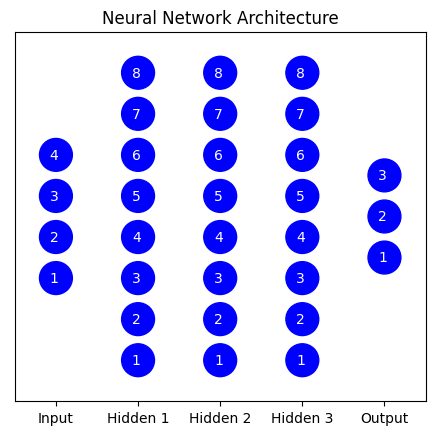

Pre-activation output before ReLU (z): (64, 16)
Forward propagation shapes for layer with weights (4, 16) and biases (16,):
a: (64, 16)
operands could not be broadcast together with shapes (64,16) (64,3) 
Layer 1: (4, 16)
Layer 2: (16, 16)
Layer 3: (16, 16)
Layer 4: (16, 3)
Biases:
Layer 1: (16,)
Layer 2: (16,)
Layer 3: (16,)
Layer 4: (3,)


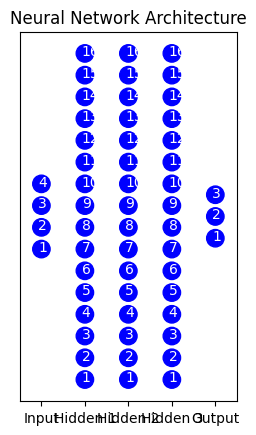

Best hyperparameters: None


TypeError: 'NoneType' object is not subscriptable

In [68]:
def main_with_grid_search():
    X_train_iris, X_test_iris, y_train_iris, y_test_iris = iris()

    # Split the training data into a training set and a validation set
    n = X_train_iris.shape[0]
    val_size = int(n * 0.1)
    train_size = n - val_size

    X_train_iris, X_val_iris = X_train_iris[:train_size], X_train_iris[train_size:]
    y_train_iris, y_val_iris = y_train_iris[:train_size], y_train_iris[train_size:]

    best_hyperparameters = grid_search(X_train_iris, y_train_iris, X_val_iris, y_val_iris)
    print(f"Best hyperparameters: {best_hyperparameters}")

    # Retrain the neural network with the best hyperparameters
    best_hidden_neurons = best_hyperparameters['hidden_layers']
    best_hidden_activations = ["ReLU"] * len(best_hidden_neurons)
    best_learning_rate = best_hyperparameters['learning_rate']

    nn_iris = NeuralNet(X_train_iris.shape[1], y_train_iris.shape[1], hidden_neurons=best_hidden_neurons, hidden_activations=best_hidden_activations, output_activation='softmax')
    # nn_iris.train_net(np.vstack((X_train_iris, X_val_iris)), np.vstack((y_train_iris, y_val_iris)), batch_size=64, epochs=100, val_split=0, verbose=False, alpha=best_learning_rate)
    test_accuracy_iris = nn_iris.accuracy(X_test_iris, y_test_iris)

    print("Test accuracy for Iris dataset with tuned hyperparameters:", test_accuracy_iris)


main_with_grid_search()